In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Build model

def build_model_deeper(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block_cSE(conv1,start_neurons * 1)
    conv1 = residual_block_cSE(conv1,start_neurons * 1)
    conv1 = residual_block_cSE(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block_cSE(conv2,start_neurons * 2)
    conv2 = residual_block_cSE(conv2,start_neurons * 2)
    conv2 = residual_block_cSE(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block_cSE(conv3,start_neurons * 4)
    conv3 = residual_block_cSE(conv3,start_neurons * 4)
    conv3 = residual_block_cSE(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block_cSE(conv4,start_neurons * 8)
    conv4 = residual_block_cSE(conv4,start_neurons * 8)
    conv4 = residual_block_cSE(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block_cSE(convm,start_neurons * 16)
    convm = residual_block_cSE(convm,start_neurons * 16)
    convm = residual_block_cSE(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8)
    uconv4 = residual_block_cSE(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4)
    uconv3 = residual_block_cSE(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2)
    uconv2 = residual_block_cSE(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1)
    uconv1 = residual_block_cSE(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [3]:


# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
SUBSET = len(train_df)
train_df = train_df.head(SUBSET)
len(train_df)

4000

In [5]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
train_df.index.values,
np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target), 
np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
train_df.coverage.values,
train_df.z.values,
test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [6]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
x_train = add_depth_bulk(x_train)
x_valid = add_depth_bulk(x_valid)
print(x_train.shape)
print(y_valid.shape)


(6400, 101, 101, 3)
(800, 101, 101, 1)


In [7]:
start_feature = 32
dropout = 0.5
batch_size = 8
base_name = 'Unet_resnet_depthinchannel_cse_{}_{}'.format(batch_size, dropout)
basic_name = '../model/{}'.format(base_name)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

# model
input_layer = Input((img_size_target, img_size_target, 3))
output_layer = build_model_deeper(input_layer, start_feature,dropout)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

board = keras.callbacks.TensorBoard(log_dir='log/{}'.format(base_name),
                       histogram_freq=0, write_graph=True, write_images=False)
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=3, min_lr=0.00001, verbose=1)

epochs = 200
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, early_stopping, model_checkpoint,reduce_lr], 
                    verbose=1)

../model/Unet_resnet_depthinchannel_cse_8_0.5.model
../model/Unet_resnet_depthinchannel_cse_8_0.5.csv
Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 146s 23ms/step - loss: 0.5506 - my_iou_metric: 0.3557 - val_loss: 2.3858 - val_my_iou_metric: 0.1939

Epoch 00001: val_my_iou_metric improved from -inf to 0.19388, saving model to ../model/Unet_resnet_depthinchannel_cse_8_0.5.model
Epoch 2/200
6400/6400 [==============================] - 132s 21ms/step - loss: 0.4072 - my_iou_metric: 0.4292 - val_loss: 0.3902 - val_my_iou_metric: 0.5304

Epoch 00002: val_my_iou_metric improved from 0.19388 to 0.53037, saving model to ../model/Unet_resnet_depthinchannel_cse_8_0.5.model
Epoch 3/200
6400/6400 [==============================] - 132s 21ms/step - loss: 0.3684 - my_iou_metric: 0.4795 - val_loss: 0.4412 - val_my_iou_metric: 0.3821

Epoch 00003: val_my_iou_metric did not improve from 0.53037
Epoch 4/200
6400/6400 [============================

6400/6400 [==============================] - 133s 21ms/step - loss: 0.1084 - my_iou_metric: 0.7429 - val_loss: 0.1538 - val_my_iou_metric: 0.7450

Epoch 00032: val_my_iou_metric did not improve from 0.74938

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 33/200
6400/6400 [==============================] - 133s 21ms/step - loss: 0.1014 - my_iou_metric: 0.7500 - val_loss: 0.1528 - val_my_iou_metric: 0.7574

Epoch 00033: val_my_iou_metric improved from 0.74938 to 0.75738, saving model to ../model/Unet_resnet_depthinchannel_cse_8_0.5.model
Epoch 34/200
6400/6400 [==============================] - 133s 21ms/step - loss: 0.0994 - my_iou_metric: 0.7500 - val_loss: 0.1530 - val_my_iou_metric: 0.7545

Epoch 00034: val_my_iou_metric did not improve from 0.75738
Epoch 35/200
6400/6400 [==============================] - 133s 21ms/step - loss: 0.0990 - my_iou_metric: 0.7550 - val_loss: 0.1569 - val_my_iou_metric: 0.7527

Epoch 00035: val_my_iou_metric did not 

In [8]:
model1 = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.00001, verbose=1)
epochs = 200

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[board, model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 197s 31ms/step - loss: 0.1582 - my_iou_metric_2: 0.7330 - val_loss: 0.1498 - val_my_iou_metric_2: 0.7250

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.72500, saving model to ../model/Unet_resnet_depthinchannel_cse_8_0.5.model
Epoch 2/200
6400/6400 [==============================] - 181s 28ms/step - loss: 0.0847 - my_iou_metric_2: 0.7418 - val_loss: 0.1518 - val_my_iou_metric_2: 0.7278

Epoch 00002: val_my_iou_metric_2 improved from 0.72500 to 0.72775, saving model to ../model/Unet_resnet_depthinchannel_cse_8_0.5.model
Epoch 3/200
6400/6400 [==============================] - 181s 28ms/step - loss: 0.0479 - my_iou_metric_2: 0.7504 - val_loss: 0.0367 - val_my_iou_metric_2: 0.7570

Epoch 00003: val_my_iou_metric_2 improved from 0.72775 to 0.75700, saving model to ../model/Unet_resnet_depthinchannel_cse_8_0.5.model
Epoch 4/200
6400/6400 [==============================] - 181s 


Epoch 00032: val_my_iou_metric_2 did not improve from 0.80525
Epoch 33/200
6400/6400 [==============================] - 183s 29ms/step - loss: -0.3100 - my_iou_metric_2: 0.8203 - val_loss: -0.1283 - val_my_iou_metric_2: 0.8038

Epoch 00033: val_my_iou_metric_2 did not improve from 0.80525
Epoch 34/200
6400/6400 [==============================] - 183s 29ms/step - loss: -0.3051 - my_iou_metric_2: 0.8219 - val_loss: -0.0887 - val_my_iou_metric_2: 0.7887

Epoch 00034: val_my_iou_metric_2 did not improve from 0.80525
Epoch 35/200
6400/6400 [==============================] - 183s 29ms/step - loss: -0.3194 - my_iou_metric_2: 0.8254 - val_loss: -0.1105 - val_my_iou_metric_2: 0.7949

Epoch 00035: val_my_iou_metric_2 did not improve from 0.80525
Epoch 36/200
6400/6400 [==============================] - 183s 29ms/step - loss: -0.3410 - my_iou_metric_2: 0.8291 - val_loss: -0.0640 - val_my_iou_metric_2: 0.7953

Epoch 00036: val_my_iou_metric_2 did not improve from 0.80525

Epoch 00036: ReduceLROnP

In [9]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})




[0.805875 0.80775  0.80725  0.808625 0.810375 0.81     0.81125  0.811
 0.811    0.8105   0.81125  0.8115   0.8125   0.811875 0.8125   0.811875
 0.811875 0.812625 0.812    0.813125 0.812375 0.812    0.811125 0.810875
 0.809625 0.80875  0.808    0.80725  0.806125 0.8055   0.804   ]


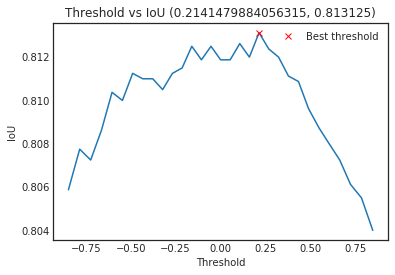

In [10]:
preds_valid = predict_result(model,x_valid,img_size_target)
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [11]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target)
x_test = add_depth_bulk(x_test)

preds_test = predict_result(model,x_test,img_size_target)

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [12]:
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub = sub.reset_index()
save_result(sub, '../result/{}.csv'.format(base_name), 
                        competition = 'tgs-salt-identification-challenge', 
                        send = True, index = False)

t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")


Usedtime = 5.151927709579468 s
save result
upload result
cmd: kaggle competitions submit -c tgs-salt-identification-challenge -f ../result/Unet_resnet_depthinchannel_cse_8_0.5.csv.7z -m "submit"
Kernel run time = 5.507533628145854 hours
